# WCP: OxCGRT clustering

## Contents

- [Introduction](#introduction)
- [Libraries](#libraries)
- [Functions and settings](#functions_and_settings)
- [Datasets collection](#datasets_collection) 
  - [List of datasets](#list_of_datasets) 
  - [Data importing](#data_importing)
  - [Data checking](#data_checking)
- [Clustering](#clustering)
  - [Geographic dataframes](#geographic_dataframes)
  - [Pipeline](#pipeline)
  - [Framework](#framework)
- [Data exporting](#data_exporting)
- [Conclusion](#conclusion)

## Introduction
<a id='introduction'></a>

<div class="alert-info">
Whether the policy actions by governments during the Covid-19 pandemic were similar or not could help us to understand the reasons for their decisions, and the consequent effects, but finding such structure can be hard with standard social science techniques. For example, we might have a theoretical prior that countries with a select cultural background, or geographic proximity, might have sought to dampen the effects of the pandemic in similar ways. But even if that was the case, are such features robust to other factors, like pandemic preparedness, income levels, and experience of infectious diseases? With extensive policy-making data available from sources such as the <a href="https://github.com/OxCGRT/covid-policy-dataset/tree/main" target="_blank">Oxford Covid-19 Government Response Tracker (OxCGRT)</a>, we now have information that might help us to see previously undetected structure in government decisions. 
    
This notebook explores such structure. Clustering alogorithms are used for detecting patterns in Covid-19 policy by governments across the world. 
    
The outputs of the clustering are discussed with the range of theoretical explanations for any of the structures that we might see, such the similarities and differences across the following and other themes:
    
- Regions. 
- Income levels. 
- State capacity. 
- Political systems. 
- Culture.
- Experience of rapidly spreading infectious diseases. 
- Pandemic preparedness. 
- Proxmity to the start of the pandemic. 
    
The first clustering steps in the notebook are used to inform the potential utility of more data collection and exploration, with a view to undertaking clustering and other modelling on larger datasets. 
   
</div>

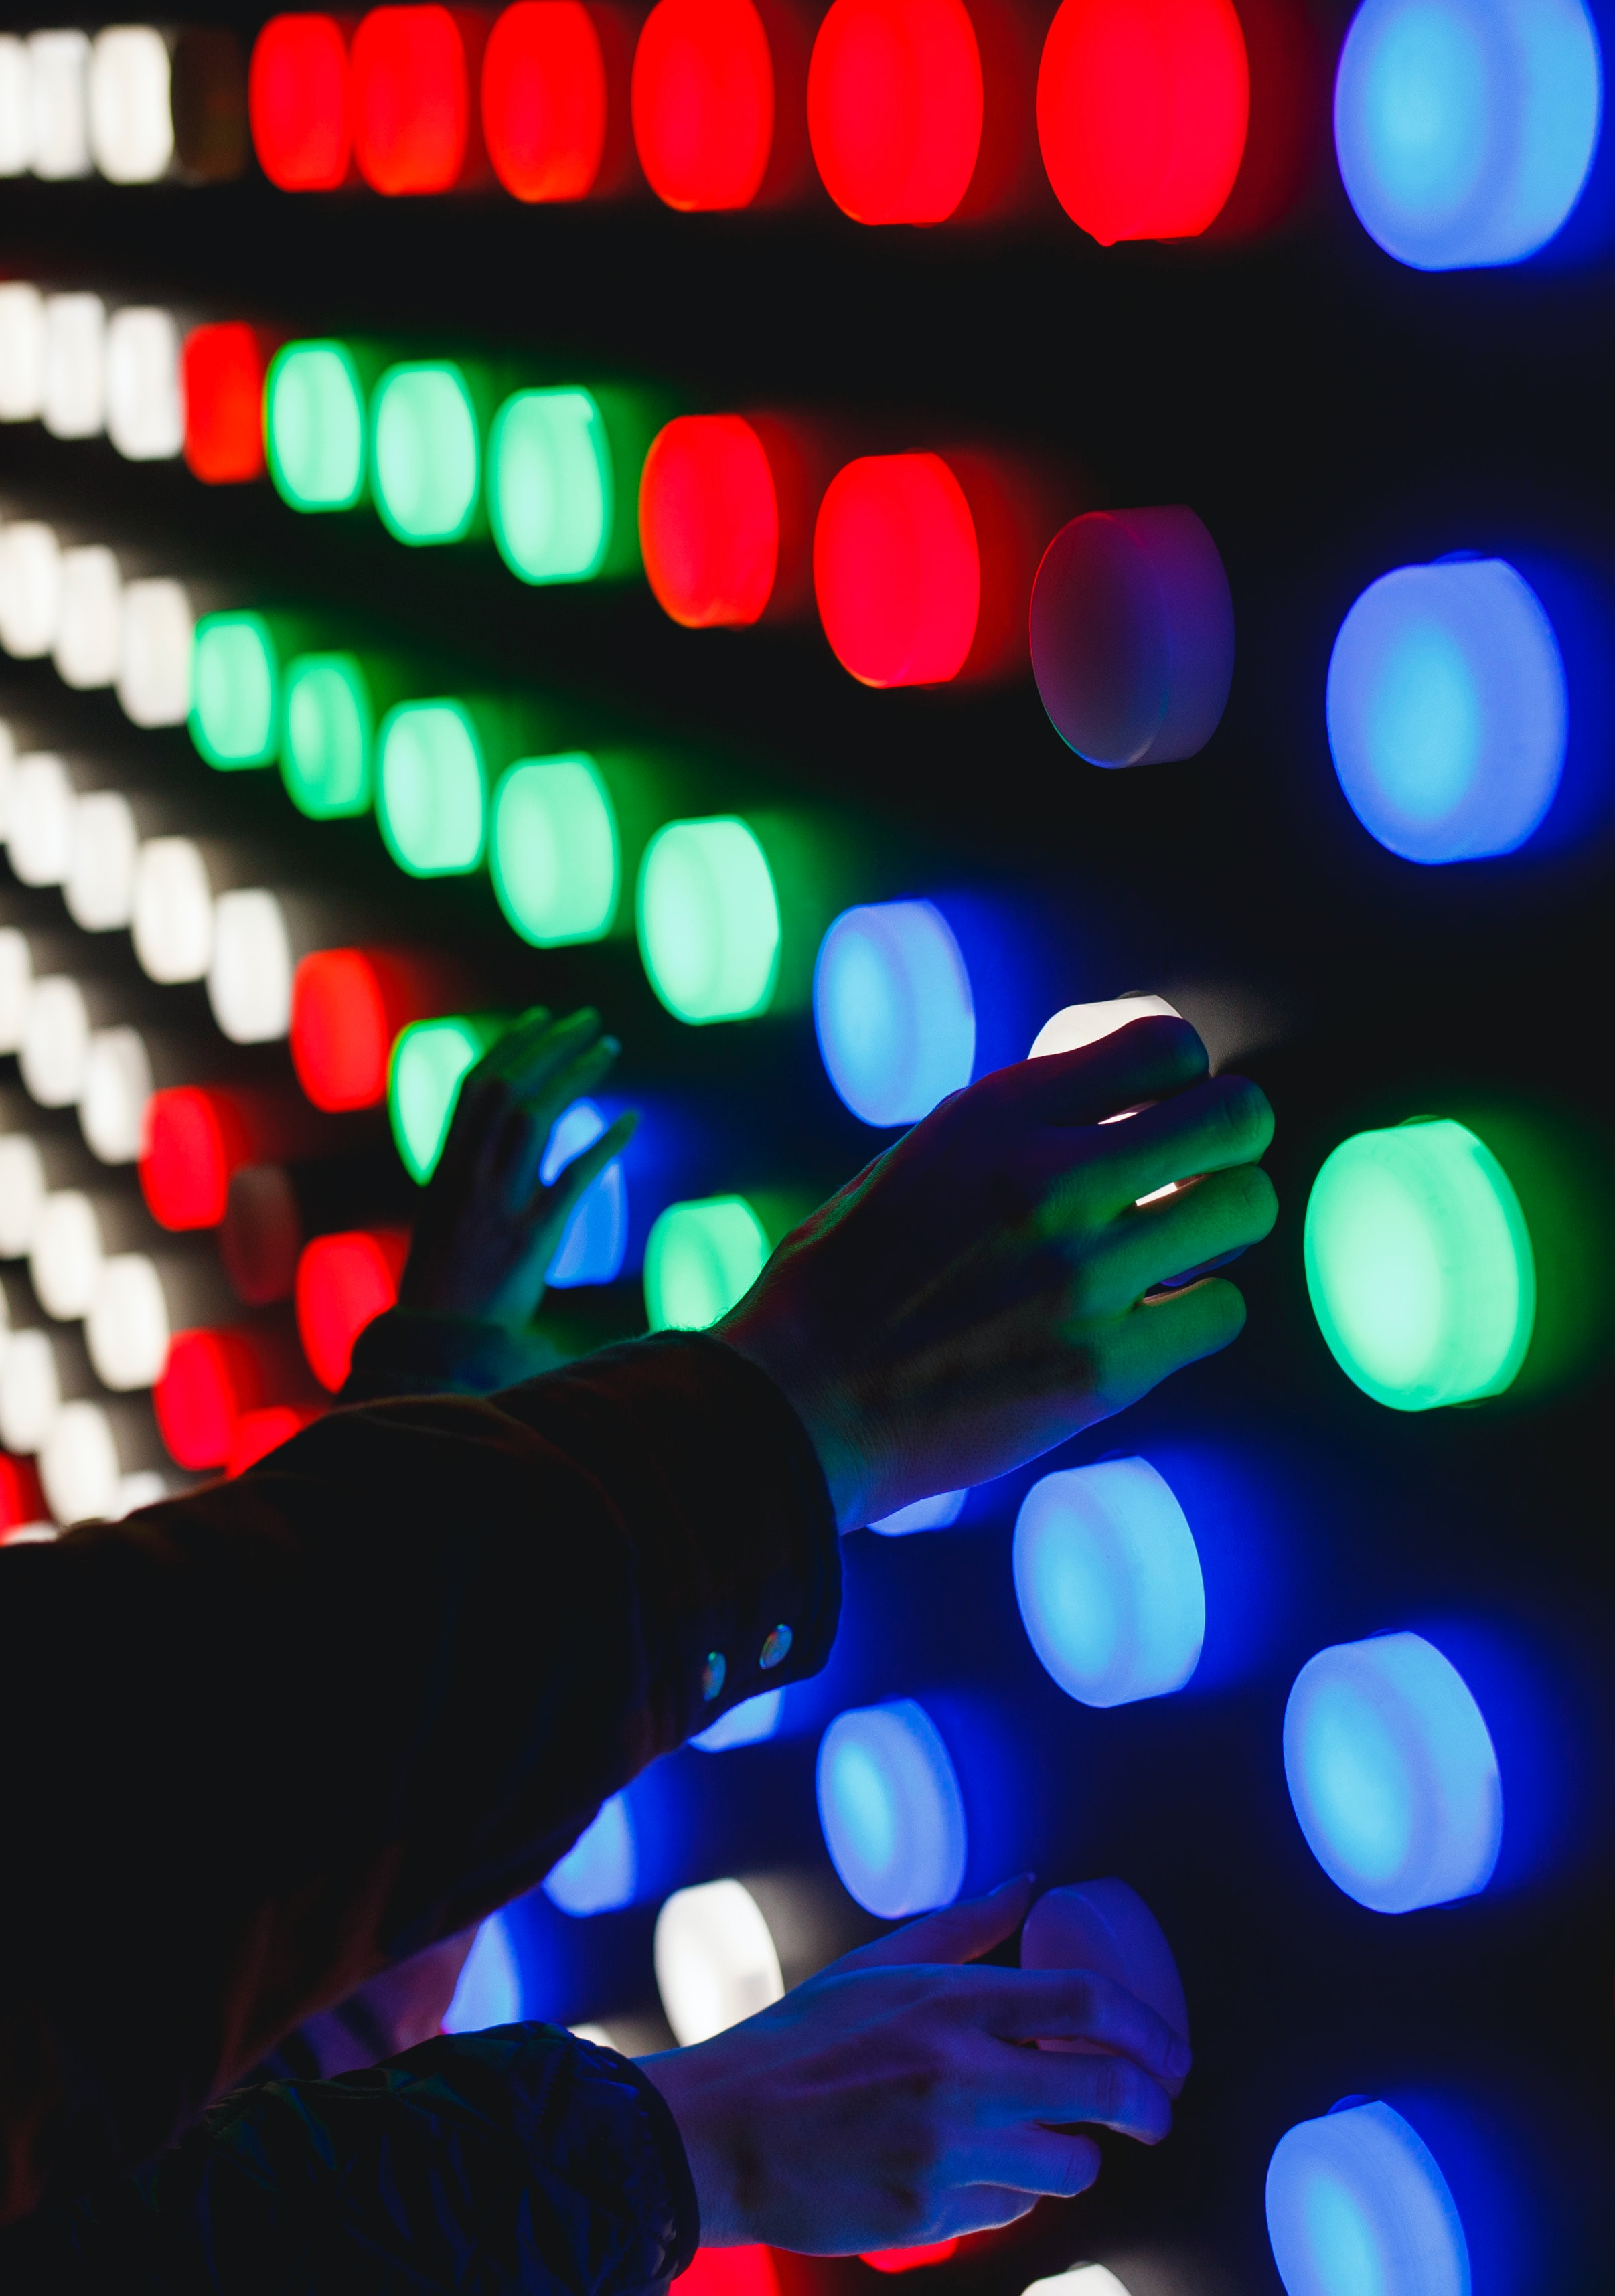

## Libraries
<a id='libraries'></a>

<div class="alert-info">
Importing libraries and packages that are used in the notebook. 
</div>

In [50]:
# Imports packages for managing and manipulating data
import pandas as pd
import numpy as np

# Imports date and time packages for dealing with such
import datetime

# Imports packages for visualising data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# Imports modelling and scaling packages
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Functions and settings
<a id='functions_and_settings'></a>

<div class="alert-info">
Stating functions and settings that are used in the notebook.
</div>

In [51]:
# EDA checking function to test for basic aspects of data quality
def EDA_checks(dataset):
    #Prints the row labels
    print('ROW LABELS')
    print('')
    print(dataset.index)
    print('')
    #Prints the column names
    print('COLUMN NAMES')
    print('')
    print(dataset.columns)
    print('')
    #Prints the number of rows and columns
    print('NUMBER OF ROWS AND COLUMNS')
    print('')
    print(dataset.shape)
    print('')
    #Prints a concise summary of the dataset
    print('CONCISE SUMMARY')
    print('')
    print(dataset.info())
    print('')
    #Prints a concise summary of the dataset
    print('DESCRIPTION OF ALL COLUMNS')
    print('')
    print(dataset.describe(include = 'all'))
    print('')
    #Prints the number of null values in the dataset
    print('NUMBER OF NULL VALUES BY COLUMN')
    print('')
    print(dataset.describe(include = 'all'))
    print('')
    print(dataset.isnull().sum())

In [52]:
# Function to check for missing and duplicated values across a dataset
def missing_and_duplicated(dataset):
    print('DUPLICATES')
    print('')
    # Gives the sum of the duplicated rows in the dataframe
    duplicated_rows_sum = dataset.duplicated().sum()   
    print(f'There are {duplicated_rows_sum} duplicated rows in the dataset.')
    print('')
    print('The duplicated rows are as follows:')
    # Locates the duplicated rows of in the dataframe
    duplicated_rows = dataset[dataset.duplicated(keep=False)]
    display(duplicated_rows)
    print('NULLS')
    print('')
    # Gives the sum of null values
    null_values_sum = dataset.isna().sum().sum()
    print(f'There are {null_values_sum} null values in the dataset.')
    print('')
    print('The null values are in the following columns:')
    # Gives missing values by the rows in the dataframe
    null_values_by_column = dataset.isna().sum(axis = 0)
    display(null_values_by_column)
    print('')
    print('The null values above account for the following percentages of all null values:')
    # Gives the number of missing entries as a percentage of the dataframe, using the result from 'shape'
    nulls_percentage = dataset.isna().sum(axis = 0) / dataset.shape[0] * 100 
    display(nulls_percentage)

In [53]:
# Function for clustering, scoring and visualisation

# Starts the function
def clustering_function(clustering_choice,
                              choice_of_dataframe, 
                              x_choice, 
                              y_choice, 
                              no_of_clusters_choice, 
                              scaler_choice,
                              chart_title_choice):

    ## Scaling data and fitting model
    
    # Scales the data
    scaled_data = scaler_choice.fit_transform(choice_of_dataframe)

    # Initialises the model
    cluster_model = clustering_choice(no_of_clusters_choice)

    # Fits the model
    cluster_model.fit(scaled_data)

    # Predicts with the model
    cluster_labels = cluster_model.predict(scaled_data)

    # Creates cluster centres from the cluster model with selected number of centres
    centers = cluster_model.cluster_centers_
    
    ## Visualising the output of the clustering model

    # Creates a canvas for the clustered output
    plt.figure(figsize=(8,8))

    # Scatters the results, uses an alpha of less than one to make the data points softer relative to the black stars
    plt.scatter(x = scaled_data[:, 0], 
                    y = scaled_data[:, 1],
                    c=cluster_labels, alpha=0.7)

    # Inserts the centres
    plt.scatter(centers[:, 0], centers[:, 1], 
            c='black', marker="*", edgecolor="white", s=700)

    # Adds a title
    plt.title(chart_title_choice)

    # Adds an X axis label
    plt.xlabel('Score')

    # Adds a Y axis label
    plt.ylabel('Score')
    
    ## Using inertia scoring to find the optimal number of clusters
    
    # Look over a range of K values
    k_range = np.arange(1, 20)

    # Instantiates an empty list of inertia scores
    inertia_list = []

    # Iterates over ks
    for k in k_range:
    
        # Instantiates the model
        looped_cluster_model = KMeans(n_clusters=k)

        # Fits the model
        looped_cluster_model.fit(scaled_data)

        # Gets inertia scopres and adds them to the list
        inertia_list.append(looped_cluster_model.inertia_)   
    
    ## Plotting the inertia scores
    
    # Creates a canvas for the inertia output scores
    plt.figure(figsize=(8,8))
    
    # Plots the inertia scores with a select marker
    plt.plot(k_range, inertia_list, marker="o")
    
    # Adds a title
    plt.title('Scree Plot for inertia scores')
    
    # Adds an X axis label
    plt.xlabel('Number of Clusters')
    
    # Adds a Y axis label
    plt.ylabel('Inertia')

    # Sets the ticks for the X axis
    plt.xticks(k_range)
    
    ## Using silhouette scoring to find the optimal number of clusters
    
    # Look over a range of K values
    k_range = np.arange(2, 20)

    # Instantiates an empty list of silhouette scores
    silhouette_scores = []

    # Iterates over ks
    for k in k_range:

        # Instantiates the model 
        looped_cluster_model = KMeans(n_clusters=k)

        # Fits the model
        looped_cluster_model.fit(scaled_data)

        # Gets cluster labels and calculates the silhouette scores
        cluster_labels = looped_cluster_model.predict(scaled_data)
        silhouette = silhouette_score(scaled_data, cluster_labels)

        # Appends the silhouette scores to the list
        silhouette_scores.append(silhouette)
        
    ## Plotting the silhouette scores
    
    # Creates a canvas for the silhouette output scores
    plt.figure(figsize=(8,8))
    
    # Plots the silhouette scores with a select marker
    plt.plot(k_range, silhouette_scores, marker="o")
    
    # Adds a title
    plt.title('Scree Plot for silhouette scores')
    
    # Adds an X axis label
    plt.xlabel('Number of Clusters')
    
    # Adds a Y axis label
    plt.ylabel('Silhouette coefficients')
    
    # Sets the ticks for the X axis
    plt.xticks(k_range)
    
    # Prints output guidance summary
    print('CLUSTERING MODEL SUMMARY')
    
    # Prints space
    print()
    
    # Prints the model selection above the chart
    print(f'Model selection: {clustering_choice} with {no_of_clusters_choice} clusters and {scaler_choice}.')
    
    # Prints the inertia score
    print(f'The inertia score is: {cluster_model.inertia_}')
    
    # Prints the silhouette score
    print(f'The silhouette score is: {silhouette_score(scaled_data, cluster_labels)}')
    
    # Prints space
    print()

## Data dictionary
<a id='data_dictionary'></a>

Variable | Description | Scores 
--- | --- | --- |
CountryName   | Name of the country | N/A
CountryCode   | Code of the country | N/A
Date   | Code of the country | N/A
C1M_combined_numeric   | Records closings of schools and universities | 0 - no measures; 1 - recommend closing or all schools open with alterations resulting in significant differences compared to non-Covid-19 operations; 2 - require closing (only some levels or categories, eg just high school, or just public schools); 3 - require closing all levels; Blank - no data
C2M_combined_numeric   | Records closings of workplaces | 0 - no measures; 1 - recommend closing (or recommend work from home) or all businesses open with alterations resulting in significant differences compared to non-Covid-19 operation; 2 - require closing (or work from home) for some sectors or categories of workers; 3 - require closing (or work from home) for all-but-essential workplaces (eg grocery stores, doctors); Blank - no data
C3M_combined_numeric   | Records cancelling public events | 0 - no measures; 1 - recommend cancelling; 2 - require cancelling; Blank - no data
C4M_combined_numeric   | Records the cut-off size for limits on gatherings | 0 - no restrictions; 1 - restrictions on very large gatherings (the limit is above 1000 people); 2 - restrictions on gatherings between 101-1000 people; 3 - restrictions on gatherings between 11-100 people; 4 - restrictions on gatherings of 10 people or less; Blank - no data
C5M_combined_numeric   | Records closing of public transport | 0 - no measures; 1 - recommend closing (or significantly reduce volume/route/means of transport available); 2 - require closing (or prohibit most citizens from using it); Blank - no data
C6M_combined_numeric   | Records orders to "shelter-in-place" and otherwise confine to the home | 0 - no measures; 1 - recommend not leaving house; 2 - require not leaving house with exceptions for daily exercise, grocery shopping, and 'essential' trips; 3 - require not leaving house with minimal exceptions (eg allowed to leave once a week, or only one person can leave at a time, etc); Blank - no data
C7M_combined_numeric   | Records restrictions on internal movement between cities/regions | 0 - no measures; 1 - recommend not to travel between regions/cities; 2 - internal movement restrictions in place; Blank - no data
C8EV_combined_numeric   | Records restrictions on international travel for foreign travellers, not citizens | 0 - no restrictions; 1 - screening arrivals; 2 - quarantine arrivals from some or all regions; 3 - ban arrivals from some regions; 4 - ban on all regions or total border closure; Blank - no data
E1_combined_numeric   | Records if the government is providing direct cash payments to people who lose their jobs or cannot work. Only includes payments to firms if explicitly linked to payroll/salaries | 0 - no income support; 1 - government is replacing less than 50% of lost salary (or if a flat sum, it is less than 50% median salary); 2 - government is replacing 50% or more of lost salary (or if a flat sum, it is greater than 50% median salary); Blank - no data
E2_combined_numeric   | Records if the government is freezing financial obligations for households (eg stopping loan repayments, preventing services like water from stopping, or banning evictions) | 0 - no debt/contract relief; 1 - narrow relief, specific to one kind of contract; 2 - broad debt/contract relief
H1_combined_numeric   | Records presence of public info campaigns | 0 - no Covid-19 public information campaign; 1 - public officials urging caution about Covid-19; 2- coordinated public information campaign (eg across traditional and social media); Blank - no data
H2_combined_numeric   | Records government policy on who has access to testing. Records policies about testing for current infection (PCR tests) not testing for immunity (antibody test) | 0 - no testing policy; 1 - only those who both (a) have symptoms AND (b) meet specific criteria (eg key workers, admitted to hospital, came into contact with a known case, returned from overseas); 2 - testing of anyone showing Covid-19 symptoms; 3 - open public testing (eg "drive through" testing available to asymptomatic people); Blank - no data
H3_combined_numeric   | Records government policy on contact tracing after a positive diagnosis | 0 - no contact tracing; 1 - limited contact tracing; not done for all cases; 2 - comprehensive contact tracing; done for all identified cases
H6M_combined_numeric   | Record policies on the use of facial coverings outside the home | 0 - No policy; 1 - Recommended; 2 - Required in some specified shared/public spaces outside the home with other people present, or some situations when social distancing not possible; 3 - Required in all shared/public spaces outside the home with other people present or all situations when social distancing not possible; 4 - Required outside the home at all times regardless of location or presence of other people
H7_combined_numeric   | Records policies for vaccine delivery for different groups | 0 - No availability; 1 - Availability for ONE of following: key workers/ clinically vulnerable groups (non elderly) / elderly groups; 2 - Availability for TWO of following: key workers/ clinically vulnerable groups (non elderly) / elderly groups; 3 - Availability for ALL of following: key workers/ clinically vulnerable groups (non elderly) / elderly groups; 4 - Availability for all three plus partial additional availability (select broad groups/ages); 5 - Universal availability
H8M_combined_numeric   | Records policies for protecting elderly people (as defined locally) in Long Term Care Facilities and/or the community and home setting | 0 - no measures; 1 - Recommended isolation, hygiene, and visitor restriction measures in LTCFs and/or elderly people to stay at home; 2 - Narrow restrictions for isolation, hygiene in LTCFs, some limitations on external visitors and/or restrictions protecting elderly people at home; 3 - Extensive restrictions for isolation and hygiene in LTCFs, all non-essential external visitors prohibited, and/or all elderly people required to stay at home and not leave the home with minimal exceptions, and receive no external visitors; Blank - no data
V1..summary.   | Summarises the existence of a prioritised plan for vaccine rollout | Blank – no data; 0 - no plan; 1 – a prioritised plan is in place; 2 – universal/general eligibility; no prioritisation between groups
V2..summary.   | Summarises vaccine availability and eligibility | N/A
V3..summary.   | Summarises the overall approach taken to vaccine funding – whether paid by the individual or the government | Blank - no data; 0 – no availability; 1 – full cost to the individual for all categories identified in V2; 2 – full cost to the individual for some categories identified in V2, some subsidy for other categories; 3- partial funding by the government for all of the categories identified in V2; 4 – partial funding by the government for some categories identified in V2, full funding for other categories; 5 – all categories fully funded by the government
StringencyIndex_Average   | Index of the stringency meaures | N/A
GovernmentResponseIndex_Average   | Index of the government response meaures | N/A
ContainmentHealthIndex_Average   | Index of the health containment meaures | N/A
EconomicSupportIndex   | Index of the economic supoort meaures | N/A

## Datasets collection
<a id='datasets_collection'></a>

<div class="alert-info">
This notebook uses the simplified covid policy data set that was originally from the <a href="https://github.com/OxCGRT/covid-policy-dataset/tree/main" target="_blank">OxCGRT Github repository</a>, and was cleaned in the <a href="https://github.com/LawrenceKay/worldwide_covid_policy/blob/main/notebooks/WCP_oxcgrt_cleaning.ipynb" target="_blank">OxCGRT cleaning notebook</a>.
    
    
    
</div>

### List of datasets
<a id='list_of_datasets'></a>

<div class="alert-info">
[Insert]
</div>

### Data importing
<a id='data_importing'></a>

<div class="alert-info">
Importing the datasets used in the notebook. 
</div>

In [54]:
# Imports the dataset
oxcgrt_simple = pd.read_csv('~/css/projects/wcp/data/oxcgrt_simple.csv', on_bad_lines='skip', low_memory=False, index_col=0)

### Data checking
<a id='data_checking'></a>

<div class="alert-info">
We've imported the data that we want. Let's do some brief checks of it before we proceed. 
</div>

In [55]:
# Checks that the data has been imported properly
oxcgrt_simple

,CountryName,CountryCode,C1M_combined_numeric,C2M_combined_numeric,C3M_combined_numeric,C4M_combined_numeric,C5M_combined_numeric,C6M_combined_numeric,C7M_combined_numeric,C8EV_combined_numeric,...,H7_combined_numeric,H8M_combined_numeric,V1..summary.,V2..summary.,V3..summary.,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex,World Bank region
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
2020-01-02,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
2020-01-03,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
2020-01-04,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
2020-01-05,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,Zimbabwe,ZWE,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1,...,5.0,0.0,2,3,5,29.48,36.44,41.65,0.0,Sub-Saharan Africa
2022-12-28,Zimbabwe,ZWE,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1,...,5.0,0.0,2,3,5,29.48,36.44,41.65,0.0,Sub-Saharan Africa
2022-12-29,Zimbabwe,ZWE,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1,...,5.0,0.0,2,3,5,29.48,36.44,41.65,0.0,Sub-Saharan Africa


In [56]:
# Runs basic EDA checks on the data
EDA_checks(oxcgrt_simple)

ROW LABELS

Index(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
       '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
       ...
       '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26',
       '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30', '2022-12-31'],
      dtype='object', name='Date', length=202760)

COLUMN NAMES

Index(['CountryName', 'CountryCode', 'C1M_combined_numeric',
       'C2M_combined_numeric', 'C3M_combined_numeric', 'C4M_combined_numeric',
       'C5M_combined_numeric', 'C6M_combined_numeric', 'C7M_combined_numeric',
       'C8EV_combined_numeric', 'E1_combined_numeric', 'E2_combined_numeric',
       'H1_combined_numeric', 'H2_combined_numeric', 'H3_combined_numeric',
       'H6M_combined_numeric', 'H7_combined_numeric', 'H8M_combined_numeric',
       'V1..summary.', 'V2..summary.', 'V3..summary.',
       'StringencyIndex_Average', 'GovernmentResponseIndex_Average',
       'ContainmentHealthInd

       CountryName CountryCode  C1M_combined_numeric  C2M_combined_numeric  \
count       202760      202760         202760.000000         202760.000000   
unique         185         185                   NaN                   NaN   
top          Aruba         ABW                   NaN                   NaN   
freq          1096        1096                   NaN                   NaN   
mean           NaN         NaN              1.141095              1.082862   
std            NaN         NaN              1.097689              0.936298   
min            NaN         NaN              0.000000              0.000000   
25%            NaN         NaN              0.000000              0.000000   
50%            NaN         NaN              1.000000              1.000000   
75%            NaN         NaN              2.000000              2.000000   
max            NaN         NaN              3.000000              3.000000   

        C3M_combined_numeric  C4M_combined_numeric  C5M_combine

In [57]:
# Checks for missing data and duplicated rows in the data
missing_and_duplicated(oxcgrt_simple)

DUPLICATES

There are 179910 duplicated rows in the dataset.

The duplicated rows are as follows:


,CountryName,CountryCode,C1M_combined_numeric,C2M_combined_numeric,C3M_combined_numeric,C4M_combined_numeric,C5M_combined_numeric,C6M_combined_numeric,C7M_combined_numeric,C8EV_combined_numeric,...,H7_combined_numeric,H8M_combined_numeric,V1..summary.,V2..summary.,V3..summary.,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex,World Bank region
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
2020-01-02,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
2020-01-03,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
2020-01-04,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
2020-01-05,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,Zimbabwe,ZWE,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1,...,5.0,0.0,2,3,5,29.48,36.44,41.65,0.0,Sub-Saharan Africa
2022-12-28,Zimbabwe,ZWE,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1,...,5.0,0.0,2,3,5,29.48,36.44,41.65,0.0,Sub-Saharan Africa
2022-12-29,Zimbabwe,ZWE,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1,...,5.0,0.0,2,3,5,29.48,36.44,41.65,0.0,Sub-Saharan Africa


NULLS

There are 0 null values in the dataset.

The null values are in the following columns:


CountryName                        0
CountryCode                        0
C1M_combined_numeric               0
C2M_combined_numeric               0
C3M_combined_numeric               0
C4M_combined_numeric               0
C5M_combined_numeric               0
C6M_combined_numeric               0
C7M_combined_numeric               0
C8EV_combined_numeric              0
E1_combined_numeric                0
E2_combined_numeric                0
H1_combined_numeric                0
H2_combined_numeric                0
H3_combined_numeric                0
H6M_combined_numeric               0
H7_combined_numeric                0
H8M_combined_numeric               0
V1..summary.                       0
V2..summary.                       0
V3..summary.                       0
StringencyIndex_Average            0
GovernmentResponseIndex_Average    0
ContainmentHealthIndex_Average     0
EconomicSupportIndex               0
World Bank region                  0
dtype: int64


The null values above account for the following percentages of all null values:


CountryName                        0.0
CountryCode                        0.0
C1M_combined_numeric               0.0
C2M_combined_numeric               0.0
C3M_combined_numeric               0.0
C4M_combined_numeric               0.0
C5M_combined_numeric               0.0
C6M_combined_numeric               0.0
C7M_combined_numeric               0.0
C8EV_combined_numeric              0.0
E1_combined_numeric                0.0
E2_combined_numeric                0.0
H1_combined_numeric                0.0
H2_combined_numeric                0.0
H3_combined_numeric                0.0
H6M_combined_numeric               0.0
H7_combined_numeric                0.0
H8M_combined_numeric               0.0
V1..summary.                       0.0
V2..summary.                       0.0
V3..summary.                       0.0
StringencyIndex_Average            0.0
GovernmentResponseIndex_Average    0.0
ContainmentHealthIndex_Average     0.0
EconomicSupportIndex               0.0
World Bank region        

<div class="alert-info">
The dataset is largely as expected. We're not missing any values and the duplicate rows is what we would expect for recordings that were often zero for many countries at the start of the pandemic. 
    
<br>
    
We only need to reset the index to datetime. 
</div>

In [58]:
# Resets the index
oxcgrt_simple.reset_index(inplace = True)

In [59]:
# Checks the change
oxcgrt_simple

,Date,CountryName,CountryCode,C1M_combined_numeric,C2M_combined_numeric,C3M_combined_numeric,C4M_combined_numeric,C5M_combined_numeric,C6M_combined_numeric,C7M_combined_numeric,...,H7_combined_numeric,H8M_combined_numeric,V1..summary.,V2..summary.,V3..summary.,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex,World Bank region
0,2020-01-01,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
1,2020-01-02,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
2,2020-01-03,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
3,2020-01-04,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
4,2020-01-05,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202755,2022-12-27,Zimbabwe,ZWE,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,5.0,0.0,2,3,5,29.48,36.44,41.65,0.0,Sub-Saharan Africa
202756,2022-12-28,Zimbabwe,ZWE,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,5.0,0.0,2,3,5,29.48,36.44,41.65,0.0,Sub-Saharan Africa
202757,2022-12-29,Zimbabwe,ZWE,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,5.0,0.0,2,3,5,29.48,36.44,41.65,0.0,Sub-Saharan Africa
202758,2022-12-30,Zimbabwe,ZWE,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,5.0,0.0,2,3,5,29.48,36.44,41.65,0.0,Sub-Saharan Africa


In [60]:
# Sets the date columnn to datetime by inferring the format
oxcgrt_simple['Date'] = pd.to_datetime(oxcgrt_simple['Date'], infer_datetime_format=True)

In [61]:
# Sets the date column as the index
oxcgrt_simple.set_index('Date', inplace=True)

In [62]:
# Checks the change
oxcgrt_simple

,CountryName,CountryCode,C1M_combined_numeric,C2M_combined_numeric,C3M_combined_numeric,C4M_combined_numeric,C5M_combined_numeric,C6M_combined_numeric,C7M_combined_numeric,C8EV_combined_numeric,...,H7_combined_numeric,H8M_combined_numeric,V1..summary.,V2..summary.,V3..summary.,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex,World Bank region
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
2020-01-02,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
2020-01-03,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
2020-01-04,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
2020-01-05,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0,0,0.00,0.00,0.00,0.0,Latin America and Caribbean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,Zimbabwe,ZWE,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1,...,5.0,0.0,2,3,5,29.48,36.44,41.65,0.0,Sub-Saharan Africa
2022-12-28,Zimbabwe,ZWE,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1,...,5.0,0.0,2,3,5,29.48,36.44,41.65,0.0,Sub-Saharan Africa
2022-12-29,Zimbabwe,ZWE,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1,...,5.0,0.0,2,3,5,29.48,36.44,41.65,0.0,Sub-Saharan Africa


## Clustering
<a id='clustering'></a>

<div class="alert-info">
We're starting the clustering with an aim, some competing explanations for any structure that we find, and data that is both simple and comprehensive. We'll use a few clustering algorithms like k-means, density-based spatial clustering of applications with noise (DBSCAN), and perhaps some Gaussian Mixture Models and hierarchical approaches, to test if there is undetected structure in the policy choices of governments during Covid-19. Doing so will necessitate working through a number of the policy variables on offer. 

<br>  
    
There are a few steps that we'll need to go through to make the application of clustering techniques to the simplified OxCGRT dataset worthwhile: 
    
 - 1) Create a clustering - modelling - pipeline that can be applied across the topics we'll look at. 
 - 2) Consider the standard explanations of underlying structure in the Covid-19 policy making data, such as those mentioned in the introduction on geography, income level and suchlike. 
 - 3) Prepare dataframes on country-level, regional data and so on, for us in the clustering. 
       
<br> 
We'll start with the third, first. 
    
</div>

### Geographic dataframes
<a id='geographic_dataframes'></a>

<div class="alert-info">
The oxcgrt_simple dataframe could be used for clustering but is too complicated for ease of use, and creting insightful comparisons, at the moment. We'll therefore reduce it to geographic levels: world, regions, and countries. Let's start with means of all of the metrics at the global level. 
</div>

In [63]:
# Resamples the dataframe to put all of the yearly measurements across the world together
oxcgrt_simple_global_datetime_yearly = oxcgrt_simple.resample('Y').mean()

In [64]:
# Checks new dataframe
oxcgrt_simple_global_datetime_yearly

,C1M_combined_numeric,C2M_combined_numeric,C3M_combined_numeric,C4M_combined_numeric,C5M_combined_numeric,C6M_combined_numeric,C7M_combined_numeric,C8EV_combined_numeric,E1_combined_numeric,E2_combined_numeric,...,H6M_combined_numeric,H7_combined_numeric,H8M_combined_numeric,V1..summary.,V2..summary.,V3..summary.,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,1.686029,1.241087,1.257503,2.246839,0.492401,0.858182,0.733090,2.474967,0.628053,0.883887,...,1.681783,0.010087,1.122929,0.017929,0.006956,0.040984,50.248240,44.761156,45.756029,37.798516
2021-12-31,1.279260,1.364235,1.336039,2.738704,0.479711,0.961644,0.628389,2.227234,0.702510,0.840711,...,2.817164,3.429308,1.228197,1.377904,1.590404,4.311899,51.805365,54.191981,56.422262,38.580526
2022-12-31,0.456505,0.642829,0.570959,0.888538,0.161770,0.205117,0.173647,0.900585,0.392477,0.387886,...,2.081710,4.919511,0.599963,1.967183,2.731507,4.957097,25.951926,35.620455,37.922052,19.509071


In [65]:
# Creates 2020 year 
oxcgrt_simple_global_datetime_yearly_2020 = oxcgrt_simple_global_datetime_yearly.loc['2020-12-31':'2020-12-31']

In [66]:
# Checks new dataframe
oxcgrt_simple_global_datetime_yearly_2020

,C1M_combined_numeric,C2M_combined_numeric,C3M_combined_numeric,C4M_combined_numeric,C5M_combined_numeric,C6M_combined_numeric,C7M_combined_numeric,C8EV_combined_numeric,E1_combined_numeric,E2_combined_numeric,...,H6M_combined_numeric,H7_combined_numeric,H8M_combined_numeric,V1..summary.,V2..summary.,V3..summary.,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,1.686029,1.241087,1.257503,2.246839,0.492401,0.858182,0.73309,2.474967,0.628053,0.883887,...,1.681783,0.010087,1.122929,0.017929,0.006956,0.040984,50.24824,44.761156,45.756029,37.798516


In [67]:
# Creates 2021 year 
oxcgrt_simple_global_datetime_yearly_2021 = oxcgrt_simple_global_datetime_yearly.loc['2021-12-31':'2021-12-31']

In [68]:
# Checks new dataframe
oxcgrt_simple_global_datetime_yearly_2021

,C1M_combined_numeric,C2M_combined_numeric,C3M_combined_numeric,C4M_combined_numeric,C5M_combined_numeric,C6M_combined_numeric,C7M_combined_numeric,C8EV_combined_numeric,E1_combined_numeric,E2_combined_numeric,...,H6M_combined_numeric,H7_combined_numeric,H8M_combined_numeric,V1..summary.,V2..summary.,V3..summary.,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,1.27926,1.364235,1.336039,2.738704,0.479711,0.961644,0.628389,2.227234,0.70251,0.840711,...,2.817164,3.429308,1.228197,1.377904,1.590404,4.311899,51.805365,54.191981,56.422262,38.580526


In [69]:
# Creates 2022 year 
oxcgrt_simple_global_datetime_yearly_2022 = oxcgrt_simple_global_datetime_yearly.loc['2022-12-31':'2022-12-31']

In [70]:
# Checks new dataframe
oxcgrt_simple_global_datetime_yearly_2022

,C1M_combined_numeric,C2M_combined_numeric,C3M_combined_numeric,C4M_combined_numeric,C5M_combined_numeric,C6M_combined_numeric,C7M_combined_numeric,C8EV_combined_numeric,E1_combined_numeric,E2_combined_numeric,...,H6M_combined_numeric,H7_combined_numeric,H8M_combined_numeric,V1..summary.,V2..summary.,V3..summary.,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-31,0.456505,0.642829,0.570959,0.888538,0.16177,0.205117,0.173647,0.900585,0.392477,0.387886,...,2.08171,4.919511,0.599963,1.967183,2.731507,4.957097,25.951926,35.620455,37.922052,19.509071


In [71]:
# Resamples the dataframe to put all of the monthly measurements across the world together
oxcgrt_simple_global_datetime_monthly = oxcgrt_simple.resample('M').mean()

In [72]:
# Checks new dataframe
oxcgrt_simple_global_datetime_monthly

,C1M_combined_numeric,C2M_combined_numeric,C3M_combined_numeric,C4M_combined_numeric,C5M_combined_numeric,C6M_combined_numeric,C7M_combined_numeric,C8EV_combined_numeric,E1_combined_numeric,E2_combined_numeric,...,H6M_combined_numeric,H7_combined_numeric,H8M_combined_numeric,V1..summary.,V2..summary.,V3..summary.,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,0.012816,0.006103,0.009677,0.007847,0.002354,0.003575,0.002354,0.103575,0.000000,0.000000,...,0.017524,0.000000,0.024412,0.000000,0.000000,0.005405,1.465810,1.362237,1.556990,0.000000
2020-02-29,0.131594,0.054054,0.073066,0.042777,0.010624,0.034296,0.018173,0.897484,0.004660,0.013234,...,0.066636,0.000000,0.080801,0.000000,0.000000,0.005405,8.361463,7.083059,8.031715,0.447344
2020-03-31,1.596164,0.885004,1.068091,1.396164,0.342023,0.536094,0.533043,2.354141,0.202441,0.301831,...,0.159285,0.000000,0.748649,0.000000,0.000000,0.005405,40.976926,31.187740,33.842094,12.606800
2020-04-30,2.842793,2.202252,1.884234,3.195225,1.056667,1.612523,1.454054,3.587207,0.710360,1.027568,...,0.871622,0.000000,1.700721,0.000000,0.000000,0.005405,78.760272,61.540886,64.125286,43.448198
2020-05-31,2.627986,1.837489,1.826591,3.182650,0.878378,1.410375,1.276373,3.521883,0.828596,1.171752,...,1.637489,0.000000,1.610201,0.000000,0.000000,0.005405,73.467667,61.098272,62.682457,50.008718
2020-06-30,2.258739,1.469279,1.618288,2.757568,0.691081,1.074234,0.956486,3.343604,0.854505,1.206306,...,1.982432,0.000000,1.394865,0.000000,0.000000,0.005405,63.860654,56.523899,57.239128,51.520270
2020-07-31,2.070445,1.349956,1.467916,2.579861,0.595641,0.891630,0.828160,3.110549,0.844202,1.173147,...,2.162511,0.000000,1.291456,0.000000,0.000000,0.005405,58.734469,53.738546,54.211114,50.433740
2020-08-31,2.043418,1.442284,1.437838,2.628858,0.545772,0.923278,0.817262,2.891194,0.849520,1.184830,...,2.443592,0.000000,1.291630,0.003139,0.000000,0.008544,58.100600,54.031433,54.484661,50.858762
2020-09-30,1.805045,1.399189,1.424595,2.629279,0.475135,0.903514,0.729369,2.693153,0.838198,1.193694,...,2.572432,0.000000,1.301441,0.005405,0.000000,0.010811,55.398323,52.811249,53.099097,50.797297


In [73]:
# Resamples the dataframe to put all of the daily measurements across the world together
oxcgrt_simple_global_datetime_daily = oxcgrt_simple.resample('D').mean()

In [74]:
# Checks the change
oxcgrt_simple_global_datetime_daily

,C1M_combined_numeric,C2M_combined_numeric,C3M_combined_numeric,C4M_combined_numeric,C5M_combined_numeric,C6M_combined_numeric,C7M_combined_numeric,C8EV_combined_numeric,E1_combined_numeric,E2_combined_numeric,...,H6M_combined_numeric,H7_combined_numeric,H8M_combined_numeric,V1..summary.,V2..summary.,V3..summary.,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010811,0.000000,0.000000,...,0.002703,0.000000,0.010811,0.000000,0.000000,0.005405,0.180216,0.223730,0.255784,0.000000
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016216,0.000000,0.000000,...,0.002703,0.000000,0.021622,0.000000,0.000000,0.005405,0.285297,0.316703,0.361946,0.000000
2020-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016216,0.000000,0.000000,...,0.002703,0.000000,0.021622,0.000000,0.000000,0.005405,0.315351,0.333568,0.381243,0.000000
2020-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016216,0.000000,0.000000,...,0.002703,0.000000,0.021622,0.000000,0.000000,0.005405,0.315351,0.367351,0.419838,0.000000
2020-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016216,0.000000,0.000000,...,0.002703,0.000000,0.021622,0.000000,0.000000,0.005405,0.330378,0.392703,0.448757,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.205405,0.267568,0.256757,0.245946,0.051351,0.043243,0.062162,0.416216,0.262162,0.281081,...,1.564865,4.935135,0.394595,1.972973,2.745946,4.951351,15.470811,26.757946,28.640324,13.581081
2022-12-28,0.205405,0.267568,0.256757,0.245946,0.051351,0.043243,0.062162,0.421622,0.262162,0.281081,...,1.564865,4.935135,0.394595,1.972973,2.745946,4.951351,15.485838,26.766432,28.649946,13.581081
2022-12-29,0.194595,0.262162,0.251351,0.229730,0.051351,0.043243,0.062162,0.410811,0.262162,0.281081,...,1.564865,4.935135,0.394595,1.972973,2.745946,4.951351,15.317351,26.671676,28.541676,13.581081


<div class="alert-info">
So we've now got a handlful of dataframes at the global level to use, split by a few of the obvious time buckets. 
    
<br>
    
Let's now move to the regions. 
</div>

In [75]:
# Groups by regions on the mean
oxcgrt_simple_regional_groups = oxcgrt_simple.groupby(by = 'World Bank region', axis = 'index').mean()

In [76]:
# Checks the change
oxcgrt_simple_regional_groups

,C1M_combined_numeric,C2M_combined_numeric,C3M_combined_numeric,C4M_combined_numeric,C5M_combined_numeric,C6M_combined_numeric,C7M_combined_numeric,C8EV_combined_numeric,E1_combined_numeric,E2_combined_numeric,...,H6M_combined_numeric,H7_combined_numeric,H8M_combined_numeric,V1..summary.,V2..summary.,V3..summary.,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex
World Bank region,,,,,,,,,,,,,,,,,,,,,
East Asia and Pacific,1.230417,1.084144,0.966258,1.868917,0.398672,0.690254,0.578433,2.459313,0.637537,0.911800,...,2.151105,2.742532,1.132772,1.108813,1.448838,3.056536,44.970216,48.179847,49.529618,38.733441
Europe and Central Asia,1.026390,1.070378,1.005518,2.012458,0.296156,0.506589,0.375974,1.720996,0.890028,0.828572,...,1.849137,2.959187,1.228190,1.195887,1.609191,3.255176,39.825789,44.985770,45.274536,42.965021
Latin America and Caribbean,1.455645,1.180009,1.121130,2.015379,0.481060,0.867789,0.615111,1.739846,0.501133,0.739316,...,2.384095,2.781684,1.171194,1.123352,1.521456,3.132682,46.622874,47.760008,50.152730,31.011229
Middle East and North Africa,1.298054,1.218717,1.237509,2.150070,0.458007,0.667905,0.626673,1.981317,0.543557,0.610315,...,2.219804,2.868396,0.843826,1.133125,1.467979,3.195777,46.428239,46.007095,48.458553,28.846781
North America,1.340024,1.098844,0.864507,2.230231,0.343978,0.758060,0.684459,2.024331,0.810827,0.719891,...,2.060979,3.059611,1.610706,1.252737,1.781630,3.368309,46.039005,49.816110,51.466262,38.267944
South Asia,1.377216,1.304419,1.133081,1.920295,0.573840,0.971389,0.748762,1.933525,0.334463,1.132430,...,2.871481,2.888556,0.836548,1.148853,1.351929,3.076512,48.653607,49.761249,51.631241,36.672315
Sub-Saharan Africa,0.874191,0.927204,1.034879,1.804869,0.322682,0.680035,0.454815,1.694633,0.251016,0.381221,...,2.379085,2.527362,0.519119,1.014910,1.161517,2.862226,38.882330,38.956508,42.263737,15.805927


In [77]:
# Groups by countries on the mean
oxcgrt_simple_country_groups = oxcgrt_simple.groupby(by = 'CountryName', axis = 'index').mean()

In [78]:
# Shows the dataframe
oxcgrt_simple_country_groups

,C1M_combined_numeric,C2M_combined_numeric,C3M_combined_numeric,C4M_combined_numeric,C5M_combined_numeric,C6M_combined_numeric,C7M_combined_numeric,C8EV_combined_numeric,E1_combined_numeric,E2_combined_numeric,...,H6M_combined_numeric,H7_combined_numeric,H8M_combined_numeric,V1..summary.,V2..summary.,V3..summary.,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex
CountryName,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.922445,1.262318,0.887318,0.620438,0.488139,0.242245,0.258668,1.357664,0.000000,0.028285,...,2.225365,2.913321,0.481296,1.208029,1.187956,3.088504,27.394580,26.088869,29.713878,0.707117
Albania,1.250000,1.194343,1.129562,2.449818,0.205292,1.164234,0.241788,1.179745,0.656022,0.767336,...,2.314781,2.711679,1.503650,1.173358,1.506387,3.284672,41.782108,44.866277,46.193239,35.583942
Algeria,1.192518,1.463504,1.462135,2.222628,0.652828,0.817518,0.528285,2.154197,0.270073,0.838504,...,2.605839,2.806569,0.854015,1.080292,1.080292,3.193431,48.367728,46.918586,49.662755,27.714416
Andorra,0.784672,1.102190,0.964416,1.722628,0.594891,0.133212,0.027372,1.165146,1.297445,0.958029,...,2.178832,2.980839,1.613139,1.186131,1.626825,3.161496,33.486770,46.759234,45.384489,56.386861
Angola,0.812956,1.824361,1.215785,2.093066,0.604471,0.877281,1.102190,2.393248,0.352190,0.167883,...,2.775547,2.844891,0.414234,1.129562,1.470803,3.047445,51.621734,44.556122,49.063431,13.001825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,1.806569,1.411040,1.100821,2.180657,0.577555,1.112226,1.006387,2.760949,0.228102,1.149635,...,3.177920,2.399635,0.677920,1.075730,1.424270,3.111314,55.201442,49.676816,51.853595,34.443431
Vietnam,1.358120,1.445255,1.233577,2.512318,0.834398,0.741332,0.931113,2.551095,0.336679,0.368613,...,2.478102,2.490876,0.865876,0.975365,1.266423,3.029197,54.682801,52.780776,57.801870,17.632299
Yemen,0.819343,0.595803,0.644161,0.000000,0.000000,0.949361,0.569343,1.945255,0.000000,0.000000,...,0.686588,1.775547,0.389142,0.577555,0.566606,2.833029,25.444097,20.958914,23.954507,0.000000


### Pipeline
<a id='pipeline'></a>

<div class="alert-info">
The function for the pipeline is on the respective section above. We'll test it now.   
</div>

In [127]:
# Function for clustering, scoring and visualisation

# Starts the function
def clustering_function(clustering_choice,
                        choice_of_dataframe, 
                        x_choice, 
                        y_choice, 
                        no_of_clusters_choice, 
                        scaler_choice,
                        chart_title_choice,
                        eps_choice,
                        min_samples_choice,
                        number_of_components_choice,
                        linkage_choice):
    
    ## Scaling the data
    scaled_data = scaler_choice.fit_transform(choice_of_dataframe)
    
    ## Pathway for KMeans clustering
    if clustering_choice == KMeans:

        ## Fitting the model

        # Initialises the model
        cluster_model = clustering_choice(no_of_clusters_choice)

        # Fits the model
        cluster_model.fit(scaled_data)

        # Predicts with the model
        cluster_labels = cluster_model.predict(scaled_data)

        # Creates cluster centres from the cluster model with selected number of centres
        centers = cluster_model.cluster_centers_

        ## Visualising the output of the clustering model

        # Creates a canvas for the clustered output
        plt.figure(figsize=(8,8))

        # Scatters the results, uses an alpha of less than one to make the data points softer relative to the black stars
        plt.scatter(x = scaled_data[:, 0], 
                        y = scaled_data[:, 1],
                        c=cluster_labels, alpha=0.7)

        # Inserts the centres
        plt.scatter(centers[:, 0], centers[:, 1], 
                c='black', marker="*", edgecolor="white", s=700)

        # Adds a title
        plt.title(chart_title_choice)

        # Adds an X axis label
        plt.xlabel('Score')

        # Adds a Y axis label
        plt.ylabel('Score')

        ## Using inertia scoring to find the optimal number of clusters

        # Look over a range of K values
        k_range = np.arange(1, 20)

        # Instantiates an empty list of inertia scores
        inertia_list = []

        # Iterates over ks
        for k in k_range:

            # Instantiates the model
            looped_cluster_model = KMeans(n_clusters=k)

            # Fits the model
            looped_cluster_model.fit(scaled_data)

            # Gets inertia scopres and adds them to the list
            inertia_list.append(looped_cluster_model.inertia_)   

        ## Plotting the inertia scores

        # Creates a canvas for the inertia output scores
        plt.figure(figsize=(8,8))

        # Plots the inertia scores with a select marker
        plt.plot(k_range, inertia_list, marker="o")

        # Adds a title
        plt.title('Scree Plot for inertia scores')

        # Adds an X axis label
        plt.xlabel('Number of Clusters')

        # Adds a Y axis label
        plt.ylabel('Inertia')

        # Sets the ticks for the X axis
        plt.xticks(k_range)

        ## Using silhouette scoring to find the optimal number of clusters

        # Look over a range of K values
        k_range = np.arange(2, 20)

        # Instantiates an empty list of silhouette scores
        silhouette_scores = []

        # Iterates over ks
        for k in k_range:

            # Instantiates the model 
            looped_cluster_model = KMeans(n_clusters=k)

            # Fits the model
            looped_cluster_model.fit(scaled_data)

            # Gets cluster labels and calculates the silhouette scores
            cluster_labels = looped_cluster_model.predict(scaled_data)
            silhouette = silhouette_score(scaled_data, cluster_labels)

            # Appends the silhouette scores to the list
            silhouette_scores.append(silhouette)

        ## Plotting the silhouette scores

        # Creates a canvas for the silhouette output scores
        plt.figure(figsize=(8,8))

        # Plots the silhouette scores with a select marker
        plt.plot(k_range, silhouette_scores, marker="o")

        # Adds a title
        plt.title('Scree Plot for silhouette scores')

        # Adds an X axis label
        plt.xlabel('Number of Clusters')

        # Adds a Y axis label
        plt.ylabel('Silhouette coefficients')

        # Sets the ticks for the X axis
        plt.xticks(k_range)

        # Prints output guidance summary
        print('CLUSTERING MODEL SUMMARY')

        # Prints space
        print()

        # Prints the model selection above the chart
        print(f'Model selection: {clustering_choice} with {no_of_clusters_choice} clusters and {scaler_choice}.')

        # Prints the inertia score
        print(f'The inertia score is: {cluster_model.inertia_}')

        # Prints the silhouette score
        print(f'The silhouette score is: {silhouette_score(scaled_data, cluster_labels)}')

        # Prints space
        print()
        
    
    ## Pathway for DBSCAN clustering
    if clustering_choice == DBSCAN:
        
        ## Fitting the model

        # Initialises the model
        #dbscan_model = DBSCAN(eps_choice, min_samples_choice)
        dbscan_model = DBSCAN(eps_choice, min_samples= min_samples_choice)

        # Fits the model and predicts labels
        cluster_labels = dbscan_model.fit_predict(scaled_data)
        
        ## Visualising the output of the clustering model

        # Creates a canvas for the clustered output
        plt.figure(figsize=(8,8))

        # Scatters the results, uses an alpha of less than one to make the data points softer relative to the black stars
        plt.scatter(x = scaled_data[:, 0], 
                    y = scaled_data[:, 1],
                    c=cluster_labels, alpha=0.7)

        # Adds a title
        plt.title(chart_title_choice)

        # Adds an X axis label
        plt.xlabel('Score')

        # Adds a Y axis label
        plt.ylabel('Score')
        
        ## Getting the silhouette scores
        
        # Creates empty list for silhouette scores
        silhouette_scores = []
        
        # Creates empty list for cluster counts
        n_clusters = []
        
        # Sets the range of ep's to loop through
        eps = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75]
        
        # Iterates over ep's
        for e in eps:

            # Instantiate a model
            dbscan_model = DBSCAN(eps=e, min_samples=min_samples_choice)

            # Fits the model and predicts labels
            cluster_labels = dbscan_model.fit_predict(scaled_data)

            # Finds the non-noise points
            non_noise = cluster_labels[cluster_labels != -1]

            # Gets the silhouette score and number of clusters
            n_cluster = len(np.unique(non_noise))

            # [Insert]
            if n_cluster > 1:
                silhouette = silhouette_score(scaled_data, cluster_labels)
            else:
                silhouette = np.NaN

            # Appends to the lists
            n_clusters.append(n_cluster)
            silhouette_scores.append(silhouette)
            
        # Put the scores into a dataframe
        silhouette_dataframe = pd.DataFrame({'eps':eps, 'n_clusters':n_clusters, 'silhouette':silhouette_scores})
        
        # Prints output guidance summary
        print('CLUSTERING MODEL SUMMARY')

        # Prints space
        print()

        # Prints the model selection above the chart
        print(f'Model selection: {clustering_choice} with {eps_choice} eps distance, {min_samples_choice} minimum samples and {scaler_choice}.')
        
        # Prints space
        print()
        
        # Prints hyper paramater search table
        print('HYPER-PARAMETER SEARCH')
        
        return silhouette_dataframe
    
    ## Pathway for Gaussian Mixture clustering
    if clustering_choice == GaussianMixture:
        
        #Initialises
        gmm = GaussianMixture(number_of_components_choice)
        
        # Fit and predict
        cluster_labels = gmm.fit_predict(scaled_data)
        
        ## Visualising the output of the clustering model

        # Creates a canvas for the clustered output
        plt.figure(figsize=(8,8))

        # Scatters the results, uses an alpha of less than one to make the data points softer relative to the black stars
        plt.scatter(x = scaled_data[:, 0], 
                    y = scaled_data[:, 1],
                    c=cluster_labels, alpha=0.7)

        # Adds a title
        plt.title(chart_title_choice)

        # Adds an X axis label
        plt.xlabel('Score')

        # Adds a Y axis label
        plt.ylabel('Score')
        
    ## Pathway for agglomerative clustering
    if clustering_choice == AgglomerativeClustering:
        
        # Initialize 
        agglomerative = AgglomerativeClustering(n_clusters=no_of_clusters_choice, linkage= linkage_choice)
        
        # Fit and predict
        cluster_labels = agglomerative.fit_predict(scaled_data)
        
        # Scatters the results, uses an alpha of less than one to make the data points softer relative to the black stars
        plt.scatter(x = scaled_data[:, 0], 
                    y = scaled_data[:, 1],
                    c=cluster_labels, alpha=0.7)
        

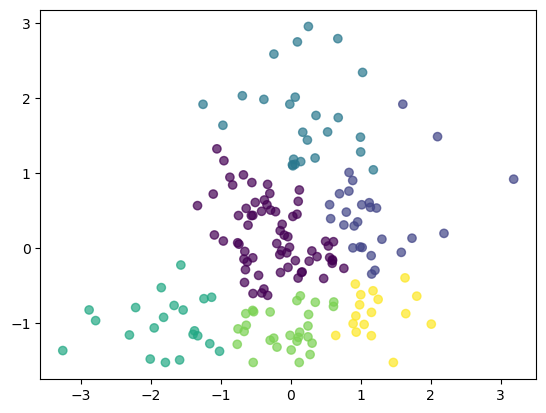

In [128]:
# Tests the function with agglomerative clustering
clustering_function(clustering_choice = AgglomerativeClustering,
                    choice_of_dataframe = oxcgrt_simple_country_groups[['StringencyIndex_Average', 'EconomicSupportIndex']],
                    x_choice = oxcgrt_simple_country_groups['StringencyIndex_Average'],
                    y_choice = oxcgrt_simple_country_groups['EconomicSupportIndex'],
                    no_of_clusters_choice = 6,
                    scaler_choice = StandardScaler(),
                    chart_title_choice = 'Function test',
                    eps_choice = None,
                    min_samples_choice = None,
                    number_of_components_choice = 2,
                    linkage_choice = 'ward')

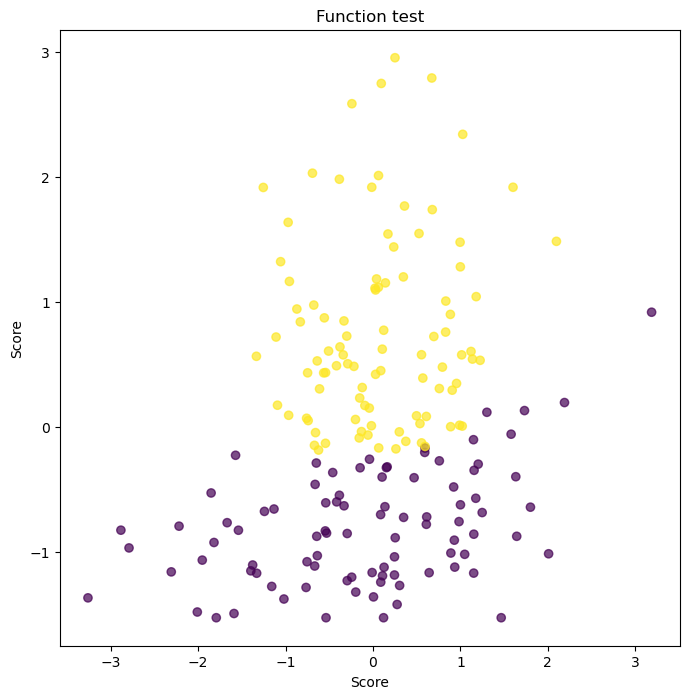

In [125]:
# Tests the function with Gaussian Mixture
clustering_function(clustering_choice = GaussianMixture,
                    choice_of_dataframe = oxcgrt_simple_country_groups[['StringencyIndex_Average', 'EconomicSupportIndex']],
                    x_choice = oxcgrt_simple_country_groups['StringencyIndex_Average'],
                    y_choice = oxcgrt_simple_country_groups['EconomicSupportIndex'],
                    no_of_clusters_choice = 6,
                    scaler_choice = StandardScaler(),
                    chart_title_choice = 'Function test',
                    eps_choice = None,
                    min_samples_choice = None,
                    number_of_components_choice = 2,
                    linkage_choice = 'ward')

CLUSTERING MODEL SUMMARY

Model selection: <class 'sklearn.cluster._kmeans.KMeans'> with 6 clusters and StandardScaler().
The inertia score is: 71.8741208071687
The silhouette score is: 0.36853356308291385



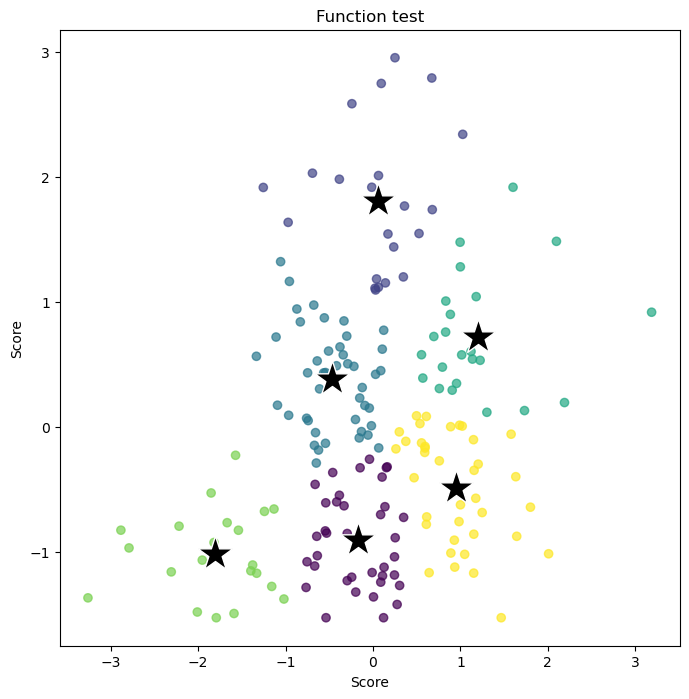

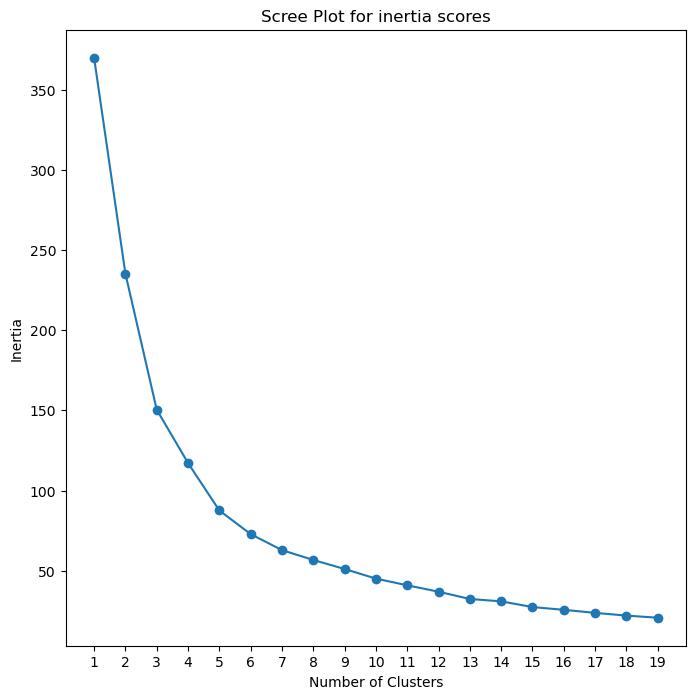

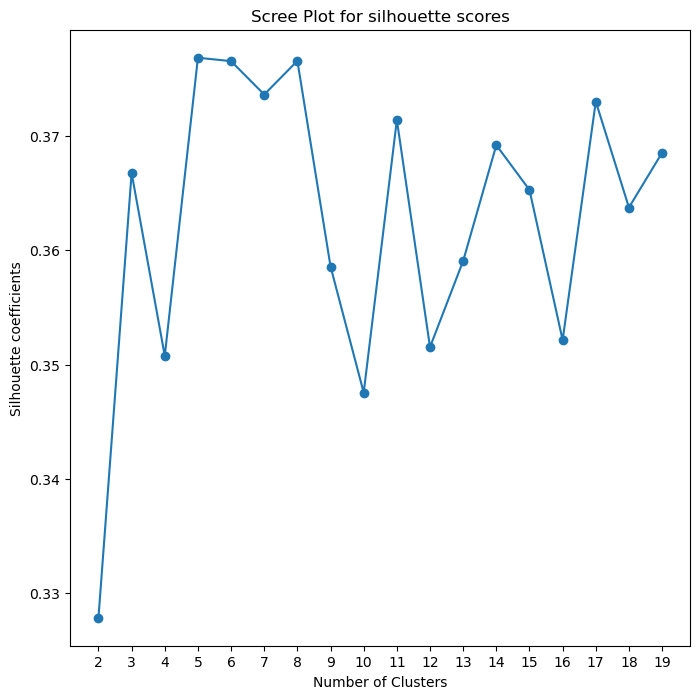

In [116]:
# Tests the function with KMeans
clustering_function(clustering_choice = KMeans,
                    choice_of_dataframe = oxcgrt_simple_country_groups[['StringencyIndex_Average', 'EconomicSupportIndex']],
                    x_choice = oxcgrt_simple_country_groups['StringencyIndex_Average'],
                    y_choice = oxcgrt_simple_country_groups['EconomicSupportIndex'],
                    no_of_clusters_choice = 6,
                    scaler_choice = StandardScaler(),
                    chart_title_choice = 'Function test',
                    eps_choice = None,
                    min_samples_choice = None,
                    number_of_components_choice = 2)

CLUSTERING MODEL SUMMARY

Model selection: <class 'sklearn.cluster._dbscan.DBSCAN'> with 0.01 eps distance, 8 minimum samples and StandardScaler().

HYPER-PARAMETER SEARCH


,eps,n_clusters,silhouette
0,0.01,0,NaN
1,0.05,0,NaN
2,0.10,0,NaN
3,0.25,4,-0.211476
4,0.50,1,NaN
5,0.75,1,NaN


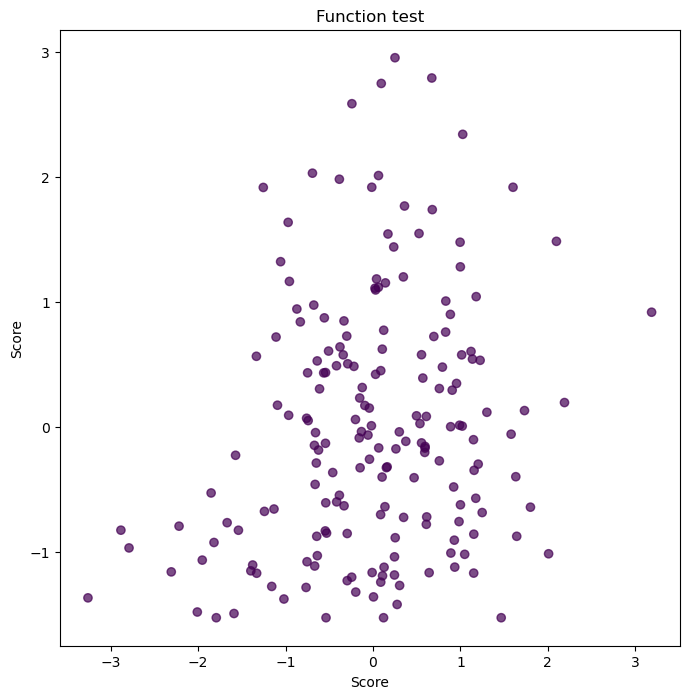

In [115]:
# Tests the function with DBSCAN
clustering_function(clustering_choice = DBSCAN,
                    choice_of_dataframe = oxcgrt_simple_country_groups[['StringencyIndex_Average', 'EconomicSupportIndex']],
                    x_choice = None,
                    y_choice = None,
                    no_of_clusters_choice = None,
                    scaler_choice = StandardScaler(),
                    chart_title_choice = 'Function test',
                    eps_choice = 0.01,
                    min_samples_choice = 8)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

<div class="alert-info">
Now that we can see the results of the pipeline, let's move to thinking about, and using, a framework for the clustering. 
</div>

### Framework
<a id='framework'></a>

<div class="alert-info">
[Insert]
</div>

## Data exporting
<a id='data_exporting'></a>

<div class="alert-info">
Exporting the clean versions of respective datasets. 
</div>

In [ ]:
# Makes the final data frame into a clean CSV
#oxcgrt_simple.to_csv('oxcgrt_simple.csv')

## Conclusion
<a id='conclusion'></a>

<div class="alert-info">
[Insert]
   
</div>